In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py

from fiesta.train.FluxTrainer import CVAETrainer, DataManager
from fiesta.inference.lightcurve_model import AfterglowFlux
from fiesta.train.neuralnets import NeuralnetConfig
from fiesta.utils import Filter
import fiesta.train.neuralnets as fiesta_nn


import pickle
import jax.random as random
import scipy.interpolate as interpolate
import jax
import jax.numpy as jnp

2025-01-07 14:46:33.173164: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
tmin = 0.1 # days
tmax = 2000


numin = 1e9 # Hz 
numax = 2.5e18

n_training = 70_000
n_val = 5000
file = "../afterglowpy_gaussian/model/afterglowpy_raw_data.h5"


data_manager_args = dict(file = file ,
                           n_training= n_training, 
                           n_val= n_val, 
                           tmin= tmin,
                           tmax= tmax,
                           numin = numin,
                           numax = numax, 
                           special_training=["02"])

data = DataManager(**data_manager_args)


with h5py.File(file, "r") as f:

    val_X = f["val"]["X"][:]
    val_y_raw = f["val"]["y"][:, data.mask]

In [3]:
with open("./model/gaussian_metadata.pkl", "rb") as meta_file:
        meta_data = pickle.load(meta_file)

state, config = fiesta_nn.CVAE.load_full_model("./model/gaussian.pkl")

In [4]:
ind = 2

In [5]:
y, x = meta_data["y_scaler"].transform(val_y_raw[ind])[0], meta_data["X_scaler"].transform(val_X[ind])
zkey = random.PRNGKey(9)
reconstructed_y, mean, logvar = state.apply_fn({'params': state.params}, y, x, zkey)

In [7]:
logflux = interpolate.interp1d(data.nus, val_y_raw[ind].reshape(len(data.nus), len(data.times)), axis = 0)(6e9)

logflux_predict = interpolate.interp1d(data.nus, meta_data["y_scaler"].inverse_transform(reconstructed_y), axis = 1)(6e9)

(1, 256, 199)


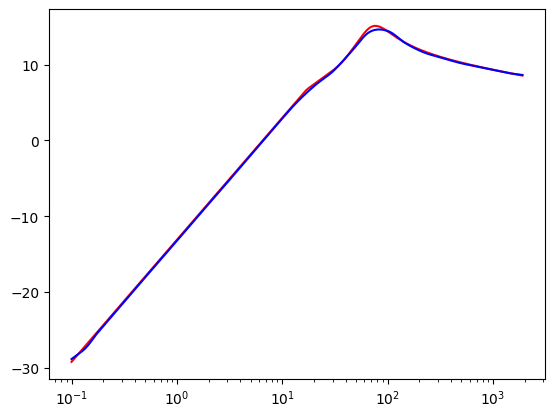

In [8]:
plt.plot(data.times, logflux, color = "red")
plt.plot(data.times, logflux_predict[0], color = 'blue')

plt.xscale("log")

# Prediction

In [9]:
state, _ = fiesta_nn.CVAE.load_model("./model/gaussian.pkl")

ind = 5

In [11]:
y, x = meta_data["y_scaler"].transform(val_y_raw[ind])[0], meta_data["X_scaler"].transform(val_X[ind])
pred_y = state.apply_fn({'params': state.params}, jnp.concatenate((jnp.zeros(20), x)) )

logflux_predict = interpolate.interp1d(data.nus, meta_data["y_scaler"].inverse_transform(pred_y), axis = 1)(2.49e18)
logflux = interpolate.interp1d(data.nus, val_y_raw[ind].reshape(len(data.nus), len(data.times)), axis = 0)(2.49e18)


(1, 256, 199)


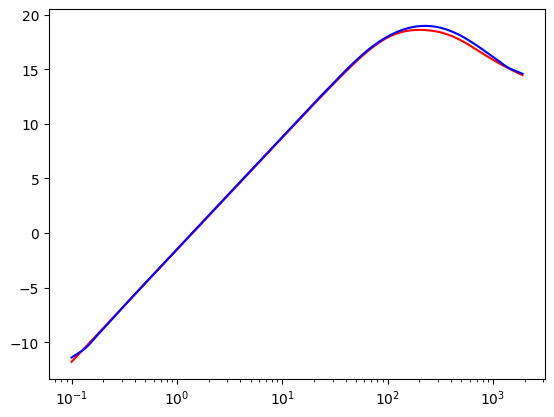

In [13]:
plt.plot(data.times, logflux, color = "red")
plt.plot(data.times, logflux_predict[0], color = 'blue')
plt.xscale("log")

In [12]:
y = val_y_raw[ind]
y = meta_data["y_scaler"].inverse_transform(meta_data["y_scaler"].transform(y))

logflux_reconstructed = interpolate.interp1d(data.nus, y.reshape(len(data.nus), len(data.times)), axis =0)(6e9)


NameError: name 'meta_data' is not defined

In [15]:
ind = 4
y = val_y_raw[ind]
logflux = interpolate.interp1d(data.nus, y.reshape(len(data.nus), len(data.times)), axis=0)(6e9)


down_size = jax.image.resize(y.reshape(256, 199), shape = (32, 25), method = "cubic")
up_size = jax.image.resize(down_size, shape = (256, 199), method = "cubic")
up_size = up_size.reshape(-1, 256, 199)
print(up_size.shape)

@jax.vmap
def fix_edges(yp):
    
    xp = jnp.arange(4, yp.shape[0]+4)
    xl = jnp.arange(0,4)
    xr = jnp.arange(yp.shape[0]+4, yp.shape[0]+8)
    
    yl = jnp.interp(xl, xp, yp, left = "extrapolate", right = "extrapolate")
    yr = jnp.interp(xr, xp, yp, left = "extrapolate", right = "extrapolate")

    out = jnp.concatenate([yl, yp, yr])
    return out


up_size = jax.vmap(fix_edges)(up_size[:, :, 4:-4])

logflux_reconstructed = interpolate.interp1d(data.nus, up_size[0], axis =0)(6e9)


(1, 256, 199)


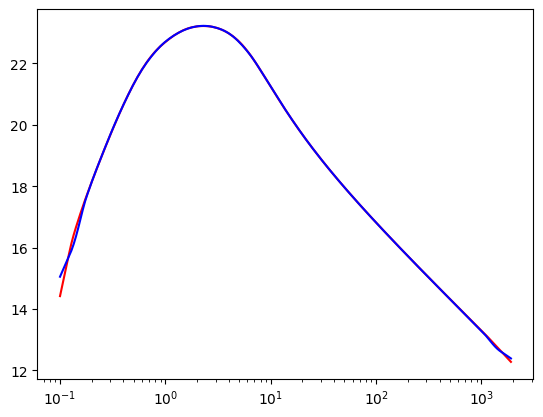

In [16]:
plt.plot(data.times, logflux, color = "red")
plt.plot(data.times, logflux_reconstructed, color = 'blue')

plt.xscale("log")

In [79]:
(up_size - y.reshape(len(data.nus), len(data.times)))[:, -4:]

Array([[-0.13311386, -0.06910133,  0.00246811,  0.0843811 ],
       [-0.08049202, -0.01647949,  0.05508995,  0.13700294],
       [-0.03312302,  0.03089333,  0.10246658,  0.18438339],
       ...,
       [ 0.14742947,  0.20141315,  0.2614298 ,  0.32312298],
       [ 0.22764778,  0.28163052,  0.3416462 ,  0.40333843],
       [ 0.31676006,  0.3707428 ,  0.43075848,  0.49245167]],      dtype=float32)

In [52]:
(up_size - y.reshape(len(data.nus), len(data.times)))[:, -4:]

Array([[-0.11424255, -0.01651955,  0.0990963 ,  0.23337173],
       [-0.0616169 ,  0.0361042 ,  0.15172005,  0.2859974 ],
       [-0.01425171,  0.08346939,  0.19908524,  0.3333664 ],
       ...,
       [ 0.1639595 ,  0.2479105 ,  0.34735775,  0.45609665],
       [ 0.24417973,  0.32812977,  0.42757797,  0.5363169 ],
       [ 0.33329105,  0.4172411 ,  0.51668835,  0.6254282 ]],      dtype=float32)

In [15]:
data.nus

array([1.00000000e+09, 1.08856575e+09, 1.18497540e+09, 1.28992363e+09,
       1.40416669e+09, 1.52852777e+09, 1.66390298e+09, 1.81126780e+09,
       1.97168410e+09, 2.14630778e+09, 2.33639715e+09, 2.54332192e+09,
       2.76857314e+09, 3.01377390e+09, 3.28069105e+09, 3.57124792e+09,
       3.88753818e+09, 4.23184092e+09, 4.60663710e+09, 5.01462738e+09,
       5.45875162e+09, 5.94221007e+09, 6.46848637e+09, 7.04137273e+09,
       7.66499720e+09, 8.34385345e+09, 9.08283311e+09, 9.88726105e+09,
       1.07629338e+10, 1.17161611e+10, 1.27538117e+10, 1.38833626e+10,
       1.51129531e+10, 1.64514432e+10, 1.79084776e+10, 1.94945554e+10,
       2.12211053e+10, 2.31005685e+10, 2.51464877e+10, 2.73736053e+10,
       2.97979693e+10, 3.24370488e+10, 3.53098605e+10, 3.84371048e+10,
       4.18413159e+10, 4.55470235e+10, 4.95809300e+10, 5.39721023e+10,
       5.87521821e+10, 6.39556134e+10, 6.96198904e+10, 7.57858283e+10,
       8.24978572e+10, 8.98043420e+10, 9.77579311e+10, 1.06415936e+11,
      

In [166]:
up_size[0, -1]

Array(6.0982194, dtype=float32)

In [162]:
jnp.arange(up_size.shape[1]-1)

Array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [163]:
up_size[0,:-1]

Array([22.861311 , 22.868547 , 22.880234 , 22.897459 , 22.922516 ,
       22.957125 , 23.000156 , 23.05052  , 23.106781 , 23.166605 ,
       23.226244 , 23.280298 , 23.324284 , 23.365026 , 23.403929 ,
       23.441214 , 23.477093 , 23.511786 , 23.545511 , 23.57848  ,
       23.610727 , 23.641687 , 23.671446 , 23.700169 , 23.728025 ,
       23.755182 , 23.781807 , 23.808065 , 23.834026 , 23.859432 ,
       23.884258 , 23.908497 , 23.93216  , 23.955236 , 23.977736 ,
       23.999653 , 24.02103  , 24.041935 , 24.062325 , 24.082125 ,
       24.101282 , 24.119743 , 24.137432 , 24.154295 , 24.170395 ,
       24.185987 , 24.200953 , 24.215168 , 24.2285   , 24.240822 ,
       24.252005 , 24.261911 , 24.270771 , 24.279163 , 24.286781 ,
       24.293276 , 24.298292 , 24.301489 , 24.302511 , 24.301012 ,
       24.297804 , 24.29452  , 24.290157 , 24.283619 , 24.273813 ,
       24.259655 , 24.240047 , 24.2139   , 24.182068 , 24.147028 ,
       24.107864 , 24.063614 , 24.0133   , 23.955942 , 23.8905

In [72]:
y.reshape(256, 199)

array([[-12.2788222 , -11.99681594, -11.71480869, ...,  28.98426565,
         28.85241771,  28.71785547],
       [-12.2505352 , -11.96852894, -11.68652169, ...,  28.91979644,
         28.7879485 ,  28.65338626],
       [-12.2222482 , -11.94024194, -11.65823469, ...,  28.85532723,
         28.7234793 ,  28.58891705],
       ...,
       [-12.44891408, -12.12543318, -11.80195223, ...,  11.31176919,
         11.21217872,  11.11086199],
       [-12.49134458, -12.16786368, -11.84438273, ...,  11.20486948,
         11.10527901,  11.00396228],
       [-12.53377509, -12.21029419, -11.88681323, ...,  11.09796977,
         10.9983793 ,  10.89706257]])

In [45]:
np.sort(np.abs(logflux - logflux_predict))

array([[1.33650635e-04, 2.14463808e-03, 6.61229559e-03, 1.45670066e-02,
        1.59352376e-02, 1.67818370e-02, 1.68454335e-02, 2.00824032e-02,
        2.11013893e-02, 2.30034622e-02, 2.53994587e-02, 2.95288963e-02,
        3.01709312e-02, 3.20487348e-02, 3.23354999e-02, 3.33471362e-02,
        3.51499019e-02, 3.65881512e-02, 3.75223792e-02, 3.79086427e-02,
        3.91199995e-02, 4.19140805e-02, 4.71693130e-02, 4.85601019e-02,
        4.93760823e-02, 5.11634700e-02, 5.22306076e-02, 5.91500356e-02,
        6.14173879e-02, 6.19559972e-02, 6.20647474e-02, 6.86591211e-02,
        6.99553210e-02, 7.00268838e-02, 7.13426988e-02, 7.28111302e-02,
        7.33424629e-02, 7.41795732e-02, 7.60438034e-02, 7.86679016e-02,
        7.91844448e-02, 7.92327219e-02, 8.55028976e-02, 8.69344482e-02,
        8.81186987e-02, 8.98954698e-02, 9.16260518e-02, 9.73311429e-02,
        1.00089360e-01, 1.05248425e-01, 1.07232091e-01, 1.07959029e-01,
        1.10010689e-01, 1.12421021e-01, 1.12423082e-01, 1.138247

In [28]:
state, config = fiesta_nn.CVAE.load_model("./model/gaussian.pkl")

In [43]:
state

TrainState(step=0, apply_fn=<bound method Module.apply of Decoder(
    # attributes
    layer_sizes = [200, 400, 600, 800]
    act_func = relu
)>, params={'layers_0': {'bias': Array([ 0.18857577,  0.0681849 ,  0.2213746 ,  0.06548748,  0.0100042 ,
        0.07243745,  0.3289603 ,  0.12806061, -0.01518959,  0.02186676,
        0.06987572,  0.0689452 ,  0.04765758,  0.13266839, -0.02004939,
        0.04123171,  0.02408954,  0.0634058 ,  0.0705937 , -0.01119579,
        0.05597618,  0.01374518,  0.10018193,  0.00372859,  0.02554698,
        0.0626522 ,  0.04558301,  0.09455661,  0.28128844,  0.30197152,
        0.19192745, -0.0461976 ,  0.07091592,  0.05062912,  0.10753687,
        0.28946486,  0.04378534,  0.02237119,  0.03310249,  0.04969371,
        0.08189752,  0.16616938,  0.04035449,  0.014731  ,  0.45297733,
        0.12119429,  0.08541467,  0.18685263,  0.01848545,  0.1873927 ,
        0.03828736,  0.01789785,  0.37191424,  0.36054727,  0.06274605,
        0.03864294, -0.1453081 ,

In [46]:
state.params["layers_0"]["kernel"].shape

(58, 200)